## Import Required Libraries

In [1]:
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt

## Read dataset

In [2]:
df = pd.read_csv("Social_Network_Ads.csv")
df.head()

,User ID,Gender,Age,EstimatedSalary,Purchased
0,15624510,Male,19,19000,0
1,15810944,Male,35,20000,0
2,15668575,Female,26,43000,0
3,15603246,Female,27,57000,0
4,15804002,Male,19,76000,0


## Preprocessing

### Drop Unwanted Columns

In [3]:
df = df.drop(columns=['User ID', 'Gender'])

## EDA

In [4]:
df['Purchased'].value_counts()

Purchased
0    257
1    143
Name: count, dtype: int64

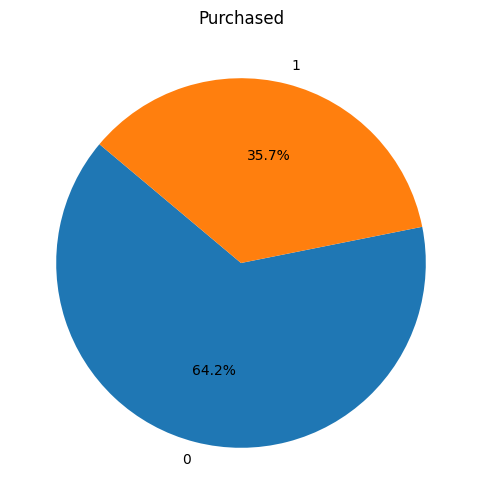

In [5]:
# Count each value in the column
value_counts = df['Purchased'].value_counts()

# Plot pie chart
plt.figure(figsize=(8, 6))
plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Purchased')
plt.show()

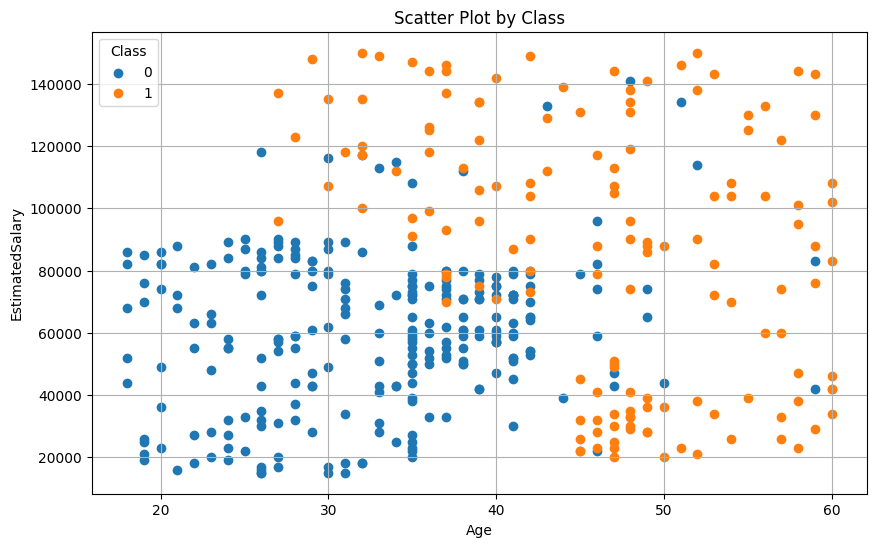

In [6]:
# Plotting
plt.figure(figsize=(10, 6))
for label in df['Purchased'].unique():
    subset = df[df['Purchased'] == label]
    plt.scatter(subset['Age'], subset['EstimatedSalary'], label=label)

plt.xlabel('Age')
plt.ylabel('EstimatedSalary')
plt.title('Scatter Plot by Class')
plt.legend(title='Class')
plt.grid(True)
plt.show()

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   Age              400 non-null    int64
 1   EstimatedSalary  400 non-null    int64
 2   Purchased        400 non-null    int64
dtypes: int64(3)
memory usage: 9.5 KB


In [8]:
df.describe()

,Age,EstimatedSalary,Purchased
count,400.000000,400.000000,400.000000
mean,37.655000,69742.500000,0.357500
std,10.482877,34096.960282,0.479864
min,18.000000,15000.000000,0.000000
25%,29.750000,43000.000000,0.000000
50%,37.000000,70000.000000,0.000000
75%,46.000000,88000.000000,1.000000
max,60.000000,150000.000000,1.000000


## Define kNN Functions

In [9]:
# Custom function to split the DataFrame into training and test sets
def train_test_split(df, test_size=0.2, target_col=None, random_state=None):
    """
    Splits a DataFrame into training and test sets.

    Parameters:
    - df: DataFrame to split.
    - test_size: Proportion of the dataset to include in the test split (default is 0.2).
    - random_state: Seed for the random number generator (default is None).
    - target_col: Name of the target column (if None, tries to infer it).

    Returns:
    - X_train: Features for the training set (DataFrame).
    - X_test: Features for the test set (DataFrame).
    - Y_train: Target for the training set (DataFrame or Series).
    - Y_test: Target for the test set (DataFrame or Series).
    """
    if random_state is not None:
        np.random.seed(random_state)

    if target_col is None:
        target_col = df.columns[df.nunique().idxmin()]

    # Shuffle the DataFrame
    shuffled_indices = np.random.permutation(len(df))
    df_shuffled = df.iloc[shuffled_indices]

    # Determine the split point
    split_index = int(len(df) * (1 - test_size))

    # Split the DataFrame
    train_df = df_shuffled.iloc[:split_index]
    test_df = df_shuffled.iloc[split_index:]

    # Separate features and target
    X_train = train_df.drop(columns=target_col)
    Y_train = train_df[[target_col]]
    X_test = test_df.drop(columns=target_col)
    Y_test = test_df[[target_col]]

    return X_train, X_test, Y_train, Y_test

# Define Euclidean distance
def euclidean_distance(point1, point2):
    return np.sqrt(np.sum((point1 - point2) ** 2))

# Define function to get k nearest neighbors
def get_neighbors(X_train, y_train, test_point, k):
    distances = []
    X_train_values = X_train.values.astype(float)  # Ensure values are floats
    y_train_values = y_train.values.ravel()  # Convert to array
    
    for i, train_point in enumerate(X_train_values):
        distance = euclidean_distance(test_point, train_point)
        distances.append((distance, y_train_values[i]))
    
    distances.sort(key=lambda x: x[0])
    neighbors = [label for _, label in distances[:k]]
    return neighbors

# Define classification function
def classify(test_point, X_train, y_train, k):
    neighbors = get_neighbors(X_train, y_train, test_point, k)
    most_common = Counter(neighbors).most_common(1)
    return most_common[0][0]

# Define function to apply k-NN
def apply_knn(X_train, X_test, y_train, y_test, k):
    X_test_values = X_test.values.astype(float)  # Ensure values are floats
    y_test_values = y_test.values.ravel()  # Convert to array
    
    predictions = []
    for test_point in X_test_values:
        prediction = classify(test_point, X_train, y_train, k)
        predictions.append(prediction)
    
    accuracy = np.mean(np.array(predictions) == np.array(y_test_values))
    return accuracy, predictions

## Test the Model

In [10]:
# np.random.seed(42)

# Use the custom train-test split function
X_train, X_test, y_train, y_test = train_test_split(df, 0.2, 'Purchased', 42)

In [11]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(320, 2)
(80, 2)
(320, 1)
(80, 1)


In [12]:
def minmax_normalize(X_train, X_test):
    """
    Normalize the features using Min-Max scaling.
    
    Parameters:
    - X_train: Training feature set.
    - X_test: Test feature set.

    Returns:
    - X_train_normalized: Normalized training feature set.
    - X_test_normalized: Normalized test feature set.
    """
    # Fit on training data
    min_values = X_train.min()
    max_values = X_train.max()
    
    # Normalize training data
    X_train_normalized = (X_train - min_values) / (max_values - min_values)
    
    # Normalize test data
    X_test_normalized = (X_test - min_values) / (max_values - min_values)
    
    return X_train_normalized, X_test_normalized

In [13]:
# Normalize the features
X_train, X_test = minmax_normalize(X_train, X_test)

In [14]:
X_train.describe()

,Age,EstimatedSalary
count,320.000000,320.000000
mean,0.470685,0.408796
std,0.254813,0.255206
min,0.000000,0.000000
25%,0.261905,0.207407
50%,0.452381,0.407407
75%,0.666667,0.540741
max,1.000000,1.000000


In [15]:
print(X_train.sample(2))

          Age  EstimatedSalary
157  0.261905         0.444444
195  0.380952         0.207407


In [16]:
# Apply k-NN with varying k values
accs = []
k_values = list(range(1, 200, 2))
for k in k_values:
    accuracy, predictions = apply_knn(X_train, X_test, y_train, y_test, k=k)
    accs.append(accuracy)
    print(f"{k}:\t {accuracy:.5f}")

1:	 0.83750
3:	 0.88750
5:	 0.88750
7:	 0.87500
9:	 0.86250
11:	 0.86250
13:	 0.87500
15:	 0.87500
17:	 0.86250
19:	 0.86250
21:	 0.86250
23:	 0.86250
25:	 0.86250
27:	 0.86250
29:	 0.86250
31:	 0.87500
33:	 0.87500
35:	 0.87500
37:	 0.87500
39:	 0.86250
41:	 0.86250
43:	 0.86250
45:	 0.86250
47:	 0.85000
49:	 0.85000
51:	 0.85000
53:	 0.85000
55:	 0.86250
57:	 0.87500
59:	 0.88750
61:	 0.86250
63:	 0.85000
65:	 0.85000
67:	 0.83750
69:	 0.83750
71:	 0.83750
73:	 0.83750
75:	 0.83750
77:	 0.83750
79:	 0.83750
81:	 0.83750
83:	 0.81250
85:	 0.80000
87:	 0.78750
89:	 0.78750
91:	 0.77500
93:	 0.76250
95:	 0.76250
97:	 0.75000
99:	 0.75000
101:	 0.75000
103:	 0.75000
105:	 0.75000
107:	 0.75000
109:	 0.75000
111:	 0.75000
113:	 0.75000
115:	 0.75000
117:	 0.75000
119:	 0.75000
121:	 0.75000
123:	 0.73750
125:	 0.73750
127:	 0.73750
129:	 0.73750
131:	 0.72500
133:	 0.72500
135:	 0.72500
137:	 0.72500
139:	 0.72500
141:	 0.72500
143:	 0.72500
145:	 0.72500
147:	 0.72500
149:	 0.72500
151:	

## Plot the k vs Accuracy

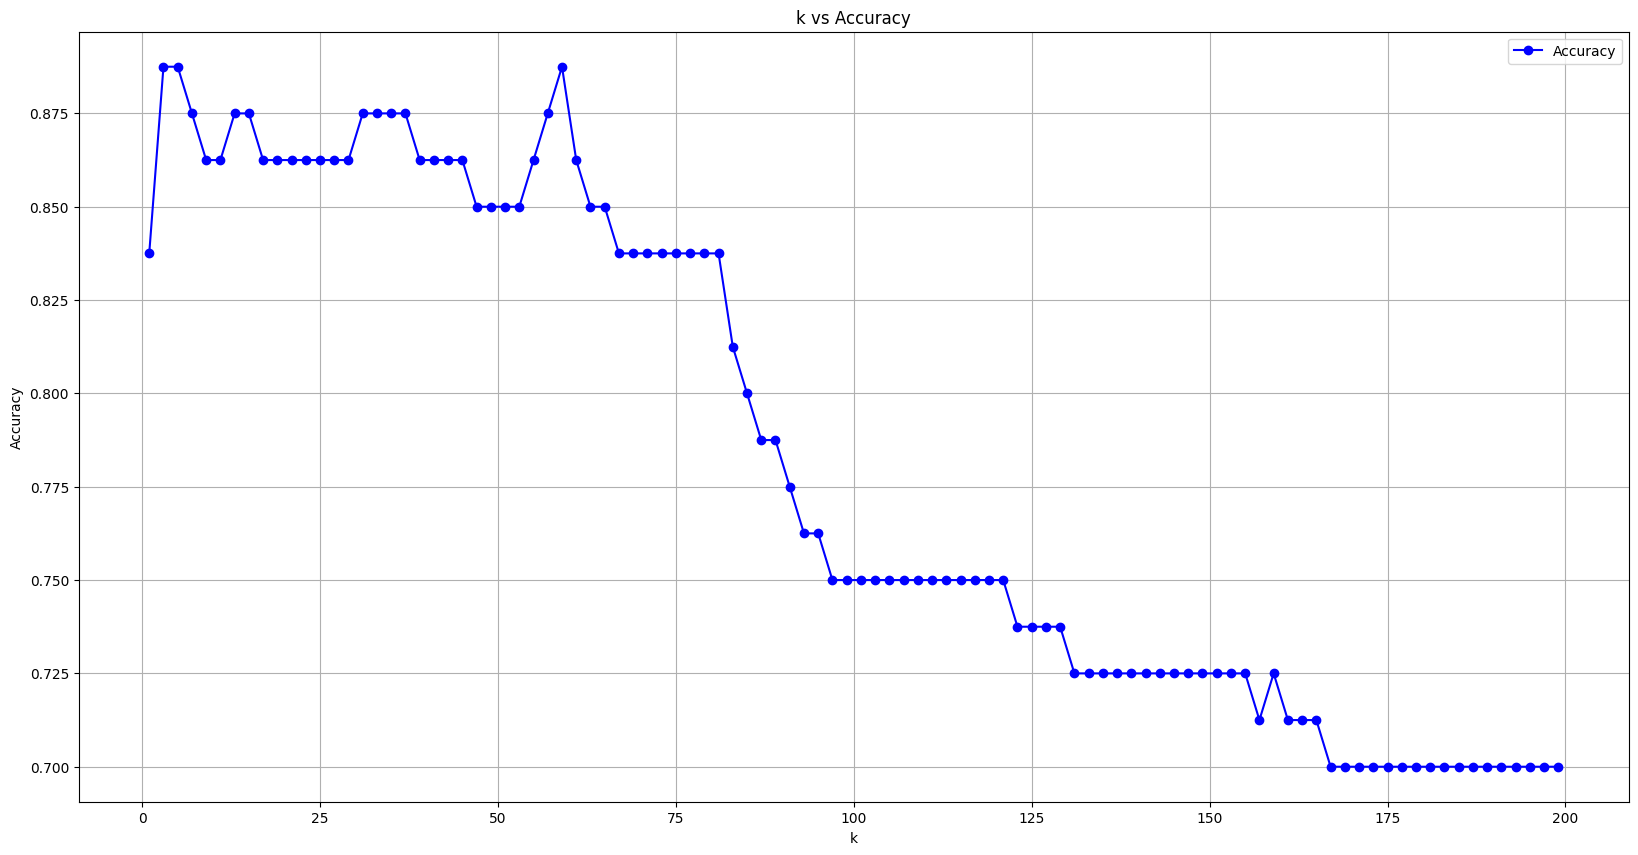

In [17]:
# %%
# Create the plot
plt.figure(figsize=(20, 10))
plt.plot(k_values, accs, marker='o', linestyle='-', color='b', label='Accuracy')

# Add titles and labels
plt.title('k vs Accuracy')
plt.xlabel('k')
plt.ylabel('Accuracy')

# Set y-axis limits for better clarity
# plt.ylim(0, 1)

# Show legend
plt.legend()

# Display the plot
plt.grid(True)
plt.show()


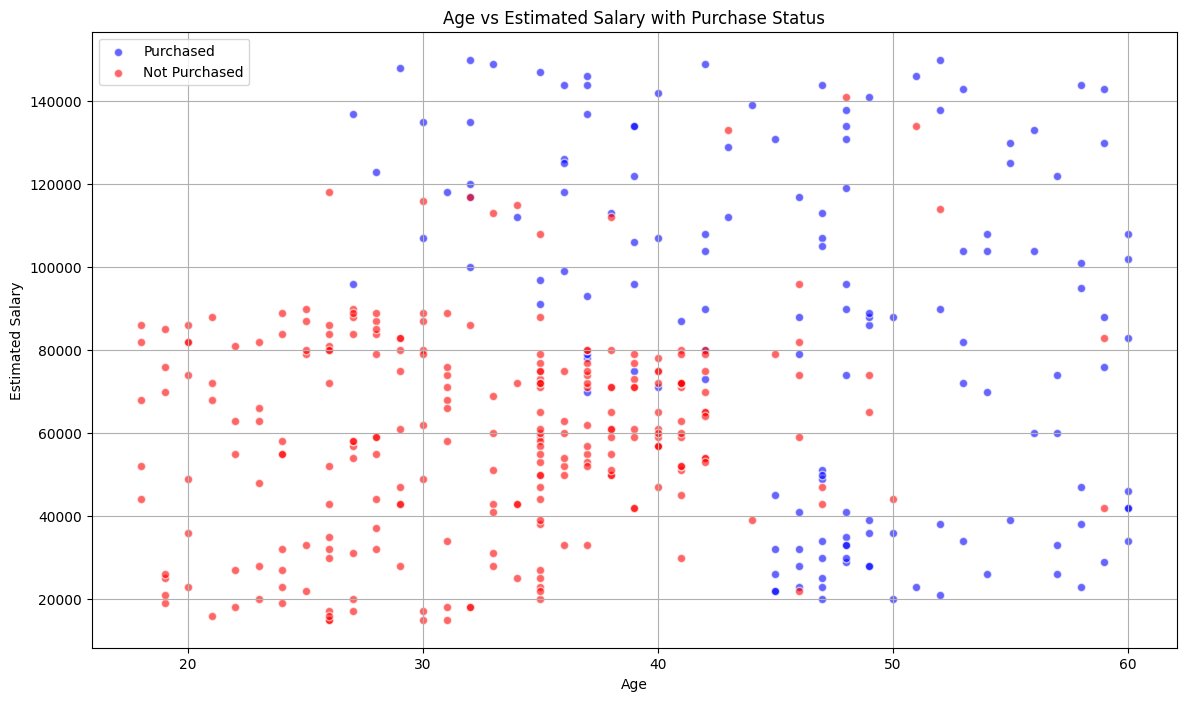

In [18]:
# %%
# Plotting Age vs EstimatedSalary with regions colored by 'Purchased'
plt.figure(figsize=(14, 8))

# Scatter plot for Purchased = 1
plt.scatter(df[df['Purchased'] == 1]['Age'], df[df['Purchased'] == 1]['EstimatedSalary'], 
            color='blue', label='Purchased', alpha=0.6, edgecolors='w')

# Scatter plot for Purchased = 0
plt.scatter(df[df['Purchased'] == 0]['Age'], df[df['Purchased'] == 0]['EstimatedSalary'], 
            color='red', label='Not Purchased', alpha=0.6, edgecolors='w')

# Add titles and labels
plt.title('Age vs Estimated Salary with Purchase Status')
plt.xlabel('Age')
plt.ylabel('Estimated Salary')

# Add legend
plt.legend()

# Display the plot
plt.grid(True)
plt.show()

## Visualization

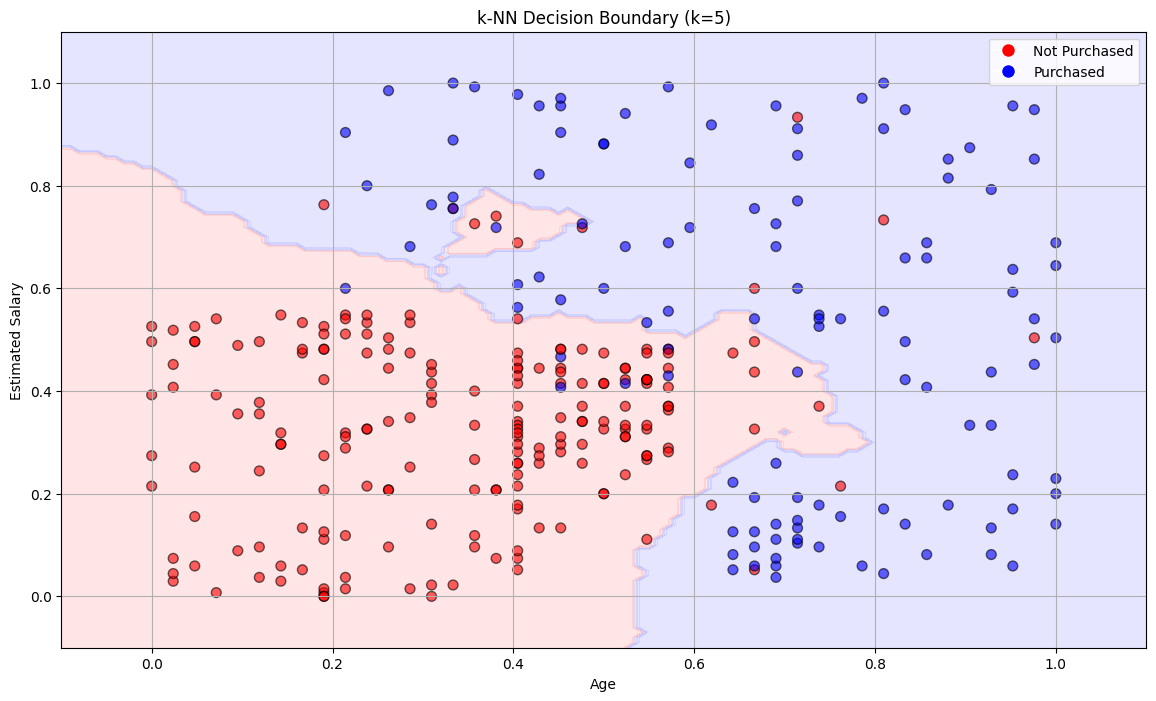

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def plot_decision_boundary(X, y, model, title):
    # Convert X to numpy array if it's a DataFrame
    if hasattr(X, 'values'):
        X = X.values

    # Ensure y is a 1D numpy array
    y = np.array(y).ravel()

    # Create a mesh grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))

    # Predict the class for each point in the grid
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Plotting the decision boundary
    plt.figure(figsize=(14, 8))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=ListedColormap(['#FFAAAA', '#AAAAFF']))

    # Plotting the data points with different colors for each class
    scatter = plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', 
                          cmap=ListedColormap(['#FF0000', '#0000FF']),
                          s=50, marker='o', alpha=0.6)

    # Add titles and labels
    plt.title(title)
    plt.xlabel('Age')
    plt.ylabel('Estimated Salary')

    # Add legend for the observation points
    plt.legend(handles=[
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#FF0000', markersize=10, label='Not Purchased'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#0000FF', markersize=10, label='Purchased')
    ], loc='best')

    # Display the plot
    plt.grid(True)
    plt.show()

def knn_model(X_train, y_train, k):
    def model(X):
        return np.array([classify(x, X_train, y_train, k) for x in X])
    return model

knn = knn_model(X_train, y_train, k=5)
plot_decision_boundary(X_train, y_train, knn, 'k-NN Decision Boundary (k=5)')